In [5]:
import numpy as np
from tools import load, estimate_derivative, expand_and_sparsify, train, test

In [6]:
n_hd = 3000                                                         # HD layer size
n_out = 6                                                           # Number of categories
k = 10                                                              # k-WTA
p = 0.2                                                             # Output synapse flip probability -> chance of potentiation if pre&post active

file_single = '1_300_20'                                            # Training sequence
file_binary = 'mix_100_20_1'                                        # Test sequence

### Load sensor data

In [7]:
single_data, single_sequence, single_times_sec, single_sequence_sec = load(file_single, reduced=True)
d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=single_data)
data_single = np.hstack((single_data, d_sensor_data))

binary_data, binary_sequence, binary_times_sec, binary_sequence_sec = load(file_binary, reduced=True)
d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=binary_data)
data_binary = np.hstack((binary_data, d_sensor_data))

# Compute labels for single dataset
single_labels = np.zeros_like(single_times_sec)
for i, t in enumerate(single_sequence_sec):
    try:
        flag = (single_times_sec > single_sequence_sec[i]) & (single_times_sec < single_sequence_sec[i+1])
    except IndexError:
        flag = (single_times_sec > single_sequence_sec[i])
    single_labels[flag] = int(single_sequence[i][1])

# Compute labels for binary dataset
binary_labels = np.zeros_like(binary_times_sec)
for i, t in enumerate(binary_sequence_sec):
    try:
        flag = (binary_times_sec > binary_sequence_sec[i]) & (binary_times_sec < binary_sequence_sec[i+1])
    except IndexError:
        flag = (binary_times_sec > binary_sequence_sec[i])
    binary_labels[flag] = int(binary_sequence[i][1])

### Expand-and-sparsify

In [8]:
W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, single_data.shape[1]))

z_hd_simple = expand_and_sparsify(single_data, single_sequence, single_times_sec, single_sequence_sec, k=k, n_hd=n_hd, W_hd=W_hd)
z_hd_binary = expand_and_sparsify(binary_data, binary_sequence, binary_times_sec, binary_sequence_sec, n_hd=n_hd, W_hd=W_hd)

### Inter/intra class inner product matrices

In [9]:
import matplotlib.pyplot as plt

def extract_samples(data, times_sec, sequence_sec, sequence):
    """Extract individual samples (frame segments between consecutive sequence times), grouped by category."""
    samples_by_cat = {}
    for i in range(len(sequence_sec)):
        cat = int(sequence[i][1])
        if i + 1 < len(sequence_sec):
            mask = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i+1])
        else:
            mask = (times_sec > sequence_sec[i])
        segment = data[mask]
        if len(segment) > 0:
            samples_by_cat.setdefault(cat, []).append(segment)
    return samples_by_cat

def compute_similarity_matrix(samples_by_cat, categories, n_pairs=100, min_frames=16, rng=None, metric='cosine'):
    """Compute average similarity between pairs of samples for all category pairs.
    metric: 'cosine' for cosine similarity, 'pearson' for Pearson correlation."""
    if rng is None:
        rng = np.random.default_rng()
    n_cat = len(categories)
    matrix = np.full((n_cat, n_cat), np.nan)

    for ci, cat_i in enumerate(categories):
        for cj, cat_j in enumerate(categories):
            if cat_i not in samples_by_cat or cat_j not in samples_by_cat:
                continue
            pool_i = samples_by_cat[cat_i]
            pool_j = samples_by_cat[cat_j]
            valid_i = [s for s in pool_i if len(s) >= min_frames]
            valid_j = [s for s in pool_j if len(s) >= min_frames]
            if len(valid_i) == 0 or len(valid_j) == 0:
                continue

            all_values = []
            for _ in range(n_pairs):
                si = valid_i[rng.integers(len(valid_i))]
                sj = valid_j[rng.integers(len(valid_j))]
                fi = si[-min_frames:]
                fj = sj[-min_frames:]

                if metric == 'cosine':
                    dot = np.sum(fi * fj, axis=1)
                    norm_i = np.linalg.norm(fi, axis=1)
                    norm_j = np.linalg.norm(fj, axis=1)
                    values = dot / (norm_i * norm_j)
                elif metric == 'pearson':
                    fi_c = fi - fi.mean(axis=1, keepdims=True)
                    fj_c = fj - fj.mean(axis=1, keepdims=True)
                    dot = np.sum(fi_c * fj_c, axis=1)
                    norm_i = np.linalg.norm(fi_c, axis=1)
                    norm_j = np.linalg.norm(fj_c, axis=1)
                    values = dot / (norm_i * norm_j)

                all_values.append(values)

            all_values = np.stack(all_values)  # (n_pairs, 16)
            matrix[ci, cj] = np.mean(all_values)

    return matrix

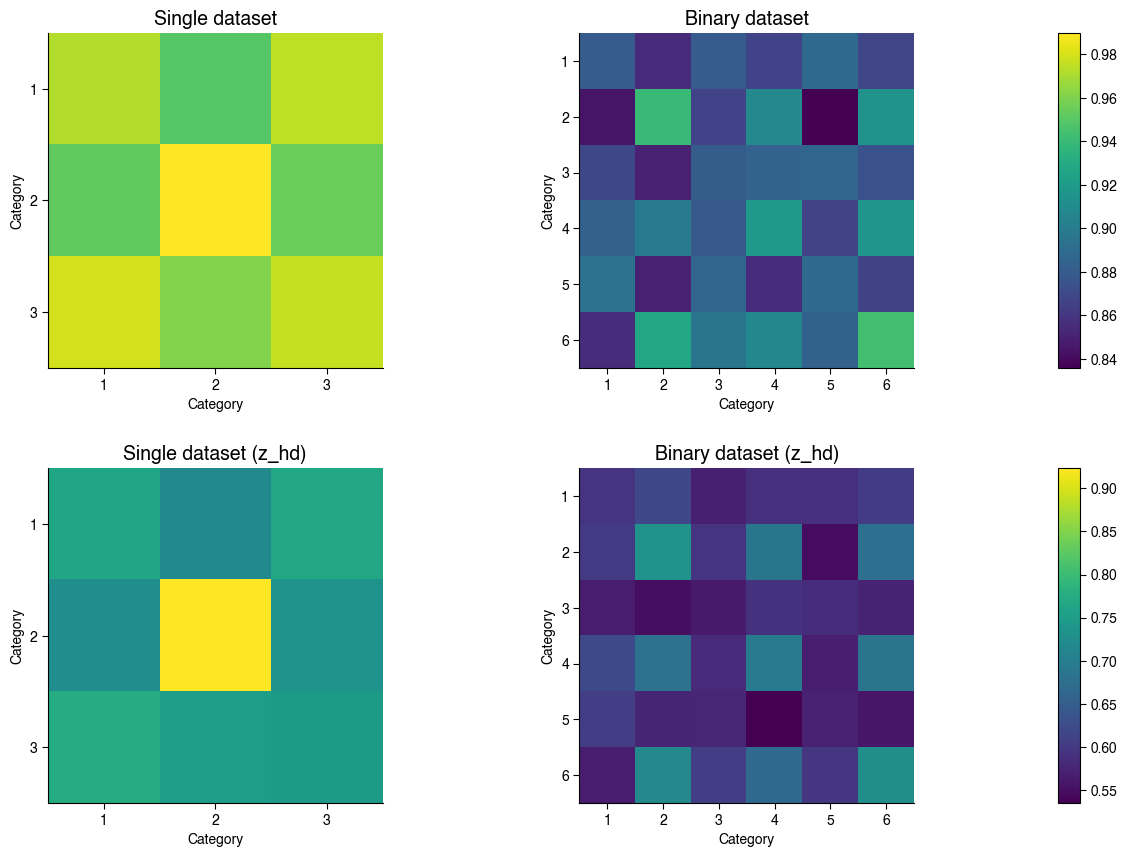

In [10]:
n_pairs = 200
rng = np.random.default_rng(42)
metric = 'cosine'

# --- Raw data ---
single_samples = extract_samples(data_single, single_times_sec, single_sequence_sec, single_sequence)
single_cats = list(range(1, 4))
single_matrix = compute_similarity_matrix(single_samples, single_cats, n_pairs=n_pairs, rng=rng, metric=metric)

binary_samples = extract_samples(data_binary, binary_times_sec, binary_sequence_sec, binary_sequence)
binary_cats = list(range(1, 7))
binary_matrix = compute_similarity_matrix(binary_samples, binary_cats, n_pairs=n_pairs, rng=rng, metric=metric)

# --- z_hd ---
rng_hd = np.random.default_rng(42)
single_samples_hd = extract_samples(z_hd_simple, single_times_sec, single_sequence_sec, single_sequence)
single_matrix_hd = compute_similarity_matrix(single_samples_hd, single_cats, n_pairs=n_pairs, rng=rng_hd, metric=metric)

binary_samples_hd = extract_samples(z_hd_binary, binary_times_sec, binary_sequence_sec, binary_sequence)
binary_matrix_hd = compute_similarity_matrix(binary_samples_hd, binary_cats, n_pairs=n_pairs, rng=rng_hd, metric=metric)

# --- Plot ---
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.05], wspace=0.3, hspace=0.3)

rows = [
    [(single_matrix, single_cats, 'Single dataset'), (binary_matrix, binary_cats, 'Binary dataset')],
    [(single_matrix_hd, single_cats, 'Single dataset (z_hd)'), (binary_matrix_hd, binary_cats, 'Binary dataset (z_hd)')],
]

for row_idx, row_data in enumerate(rows):
    vmin = min(np.nanmin(m) for m, _, _ in row_data)
    vmax = max(np.nanmax(m) for m, _, _ in row_data)
    for col_idx, (matrix, cats, title) in enumerate(row_data):
        ax = fig.add_subplot(gs[row_idx, col_idx])
        ax.imshow(matrix, cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_xticks(range(len(cats)))
        ax.set_yticks(range(len(cats)))
        ax.set_xticklabels(cats)
        ax.set_yticklabels(cats)
        ax.set_title(title)
        ax.set_xlabel('Category')
        ax.set_ylabel('Category')
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin, vmax))
    cax = fig.add_subplot(gs[row_idx, 2])
    fig.colorbar(sm, cax=cax)

plt.show()

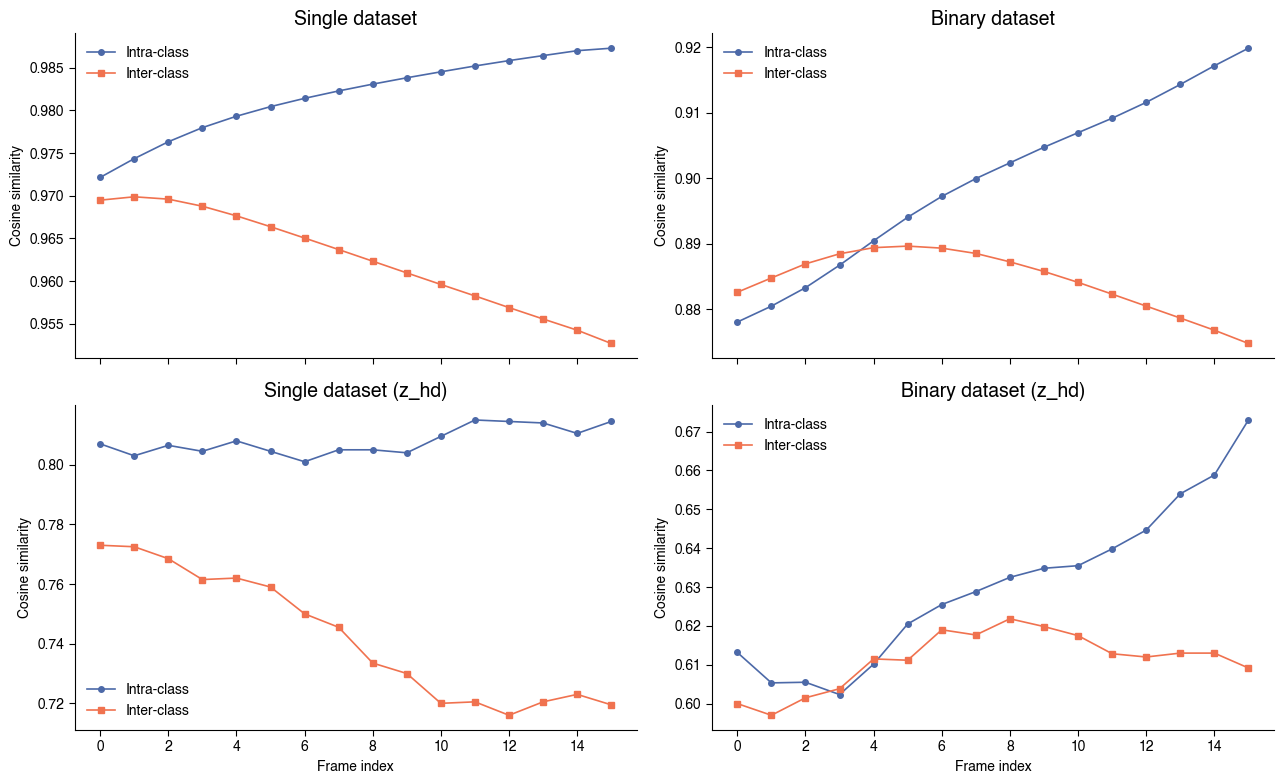

In [11]:
def compute_inter_intra_curves(samples_by_cat, categories, n_pairs=200, min_frames=16, rng=None):
    """Compute per-frame cosine similarity averaged across intra-class and inter-class pairs."""
    if rng is None:
        rng = np.random.default_rng()

    # Build flat list of valid samples with their category
    valid = []
    for cat in categories:
        if cat not in samples_by_cat:
            continue
        for s in samples_by_cat[cat]:
            if len(s) >= min_frames:
                valid.append((cat, s))

    intra_all = []
    inter_all = []
    for _ in range(n_pairs):
        # Intra-class: pick a random category, then two different samples from it
        intra_cats = [c for c in categories if len([v for v in valid if v[0] == c]) >= 2]
        if len(intra_cats) > 0:
            cat = intra_cats[rng.integers(len(intra_cats))]
            pool = [v[1] for v in valid if v[0] == cat]
            idx = rng.choice(len(pool), size=2, replace=False)
            fi = pool[idx[0]][-min_frames:]
            fj = pool[idx[1]][-min_frames:]
            dot = np.sum(fi * fj, axis=1)
            intra_all.append(dot / (np.linalg.norm(fi, axis=1) * np.linalg.norm(fj, axis=1)))

        # Inter-class: pick two different categories, one sample each
        if len(categories) >= 2:
            cats_pair = rng.choice(categories, size=2, replace=False)
            pool_i = [v[1] for v in valid if v[0] == cats_pair[0]]
            pool_j = [v[1] for v in valid if v[0] == cats_pair[1]]
            if len(pool_i) > 0 and len(pool_j) > 0:
                fi = pool_i[rng.integers(len(pool_i))][-min_frames:]
                fj = pool_j[rng.integers(len(pool_j))][-min_frames:]
                dot = np.sum(fi * fj, axis=1)
                inter_all.append(dot / (np.linalg.norm(fi, axis=1) * np.linalg.norm(fj, axis=1)))

    intra_curve = np.mean(np.stack(intra_all), axis=0) if intra_all else np.full(min_frames, np.nan)
    inter_curve = np.mean(np.stack(inter_all), axis=0) if inter_all else np.full(min_frames, np.nan)
    return intra_curve, inter_curve

rng = np.random.default_rng(42)
intra_single, inter_single = compute_inter_intra_curves(single_samples, single_cats, n_pairs=n_pairs, rng=rng)

rng = np.random.default_rng(42)
intra_binary, inter_binary = compute_inter_intra_curves(binary_samples, binary_cats, n_pairs=n_pairs, rng=rng)

rng = np.random.default_rng(42)
intra_single_hd, inter_single_hd = compute_inter_intra_curves(single_samples_hd, single_cats, n_pairs=n_pairs, rng=rng)

rng = np.random.default_rng(42)
intra_binary_hd, inter_binary_hd = compute_inter_intra_curves(binary_samples_hd, binary_cats, n_pairs=n_pairs, rng=rng)

# --- Plot ---
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex=True)
frames = np.arange(16)

for ax, intra, inter, title in [
    (axes[0, 0], intra_single, inter_single, 'Single dataset'),
    (axes[0, 1], intra_binary, inter_binary, 'Binary dataset'),
    (axes[1, 0], intra_single_hd, inter_single_hd, 'Single dataset (z_hd)'),
    (axes[1, 1], intra_binary_hd, inter_binary_hd, 'Binary dataset (z_hd)'),
]:
    ax.plot(frames, intra, '-o', label='Intra-class', markersize=4)
    ax.plot(frames, inter, '-s', label='Inter-class', markersize=4)
    ax.set_title(title)
    ax.set_ylabel('Cosine similarity')
    ax.legend()

axes[1, 0].set_xlabel('Frame index')
axes[1, 1].set_xlabel('Frame index')
plt.tight_layout()
plt.show()